Using TensorFlow backend.


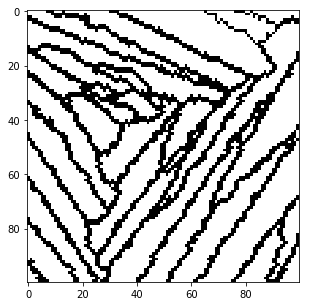

In [1]:
import scipy.io as sio
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
height=100
width =100

W1 = np.array(sio.loadmat('weights/W1_Ti.mat')['W'],dtype='float32')
W2 = np.array(sio.loadmat('weights/W2_Ti.mat')['W'],dtype='float32')
# W3 = np.array(sio.loadmat('weights_AE/W3_AE.mat')['weights_3'],dtype='float32')
bias1=np.array(sio.loadmat('weights/bias1_Ti.mat')['bias'],dtype='float32')
bias2=np.array(sio.loadmat('weights/bias2_Ti.mat')['bias'],dtype='float32')
# bias3=np.array(sio.loadmat('weights_AE/bias3_AE.mat')['biases_3'],dtype='float32')

# images = np.array(sio.loadmat('WB_test64_GAN_sm2.mat')['WB_sm'],dtype='float32')
images = np.array(sio.loadmat('alloy_mat/WB_sm.mat')['WB_sm'],dtype='float32')
# images2= np.array(sio.loadmat('WB.mat')['WB'],dtype='float32')
images = images[0:100]
# images_style = np.array(sio.loadmat('WB_raw2.mat')['WB'],dtype='float32')
images_style = images[1]
images[images==0]=0
images_style[images_style==0]=0
# images_style.shape
# plt.imshow(images[25].reshape(height,width),'gray')
plt.figure(figsize=(5, 5))
plt.imshow(images_style.reshape(100,100),'gray')

In [2]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="SAME"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
#     features_mean,features_var =tf.nn.moments(features,axes=[0])    
    features_mean = tf.reduce_mean(features,0)
    features = (features-features_mean)/1
    gram = backend.dot(features, backend.transpose(features))
#     D=tf.sqrt(tf.diag(tf.diag_part(gram)))
#     Q=tf.matmul(tf.matmul(tf.matrix_inverse(D),gram),tf.matrix_inverse(D))
#     return (gram-tf.reduce_min(tf.reshape(gram,[-1])))/(tf.reduce_max(tf.reshape(gram,[-1]))-tf.reduce_min(tf.reshape(gram,[-1]))) 
#     gram_dig = tf.diag_part(gram)   
    return gram

def style_loss(style, combination):
    loss_temp=0.
    channels = 1
    size = height * width
    
#     S = gram_matrix(style/1)
    for i in range(mb_size):
        print(combination.get_shape)
        C = gram_matrix(combination[i])
        S = gram_matrix(style[i])
        loss_temp = tf.add(loss_temp,backend.sum(backend.square(S - C)))/1*1e-2
    
    return loss_temp

# def total_variation_loss(x):
#     a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
#     b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
#     return backend.sum(backend.pow(a + b, 1.25))


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
import random
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data

mb_size = 20
z_dim = 100/4
X_dim = images.shape[1]
width = 100
hight = 100
h_dim = width/4*hight/4
input_dim = width
Rad = input_dim/2

conv1_features=64*2
conv2_features=32*2
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64*2
num_channels_3=32*2
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(width, hight), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


# =============================== Q(z|X) ======================================

# X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
x_input_shape = (mb_size, width, hight, num_channels_1)
X = tf.placeholder(tf.float32, shape=x_input_shape)

style_image = tf.placeholder(tf.float32, shape=(mb_size,height,width,1))

# conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
#                                                stddev=0.1, dtype=tf.float32))
# conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X):
#     conv1 = tf.nn.conv2d(X, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
#     h1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
#     h1 = tf.reshape(h1,[mb_size,X_dim])
    
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps

# =============================== P(X|z) ======================================
def P(z):
    h1 = tf.nn.relu(tf.matmul(z, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, hight/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, hight/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, hight/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.sigmoid(h4)
    return prob


P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

# P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                               stddev=0.1, dtype=tf.float32))
deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                               stddev=0.1, dtype=tf.float32))
deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                               stddev=0.1, dtype=tf.float32))
deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))

W_conv1 = tf.reshape(tf.constant(W1),[12,12,1,64])
W_conv2 = tf.reshape(tf.constant(W2),[12,12,64,128])
# W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])

b_conv1 = tf.reshape(tf.constant(bias1),[-1])
b_conv2 = tf.reshape(tf.constant(bias2),[-1])
# =============================== TRAINING ====================================

z_mu, z_logvar = Q(X)
z_sample = sample_z(z_mu, z_logvar)
prob = P(z_sample)

# Sampling from random z
X_samples = P(z)

# combination_image=tf.reshape(X_samples[0],[1, height, width, 1])
combination_image=tf.reshape(X_samples,[mb_size, height, width, 1])
############# white noise ############
# combination_image = tf.nn.sigmoid(combination_image)
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.bias_add(conv_out1, b_conv1)
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=1, stride=2, padding="SAME")

conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
conv_out2 = tf.nn.bias_add(conv_out2, b_conv2/1)
conv_out2 = tf.nn.relu(conv_out2)
conv_out2 = max_pool(conv_out2, k_size=1, stride=2, padding="SAME")

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.bias_add(conv_out1_S, b_conv1)
conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=1, stride=2, padding="SAME")

conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
conv_out2_S = tf.nn.bias_add(conv_out2_S, b_conv2/1)
conv_out2_S = tf.nn.relu(conv_out2_S)
conv_out2_S = max_pool(conv_out2_S, k_size=1, stride=2, padding="SAME")

sl1 = style_loss(conv_out1_S,conv_out1)
sl2 = style_loss(conv_out2_S,conv_out2)*5e-6
# sl3 = style_loss(conv_out3[0,:,:,:], conv_out3_S[0,:,:,:])


# gram_test1 =gram_matrix(conv_out1)
# gram_test2 =gram_matrix(conv_out2[0,:,:,:])

# vl = total_variation_loss(combination_image)

# point correlation loss
# PC_ori=correlation_fun(X, input_dim=input_dim, Rad=Rad)
# PC_rec=correlation_fun(prob, input_dim=input_dim, Rad=Rad)
# PC_ran=correlation_fun(X_samples,input_dim=input_dim, Rad=Rad)

# PC_loss1=tf.abs(PC_ori-PC_rec)
# PC_loss2=tf.abs(PC_ori-PC_ran)

# E[log P(X|z)]
recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-
                                                     tf.reshape(X,[mb_size, X_dim]))), 1))/4
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
kl_loss =tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))



# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)
tot_loss = tf.reduce_mean(recon_loss + kl_loss + sl1 + sl2)

solver_VAE0 = tf.train.AdamOptimizer(learning_rate=lr).minimize(vae_loss)
solver_VAE1 = tf.train.AdamOptimizer(learning_rate=lr/10).minimize(vae_loss)

solver_ST0 = tf.train.AdamOptimizer(learning_rate=lr).minimize(tot_loss)
solver_ST1 = tf.train.AdamOptimizer(learning_rate=lr/10).minimize(tot_loss)
solver_ST2 = tf.train.AdamOptimizer(learning_rate=lr/100).minimize(tot_loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0
PC_ori=[]
saver = tf.train.Saver()

for it in range(600000):
#     X_mb = images[(it*10)%100:(it*10)%100+mb_size]
    X_mb = images[random.sample(range(len(images)),  mb_size)]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
    _, loss, recon_E, kl_E = sess.run([solver_VAE0, vae_loss, recon_loss, kl_loss], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim)})
    
#    
#     _, loss_tot, recon_E, kl_E, style_E= sess.run([solver_ST0, tot_loss, recon_loss, kl_loss, sl1], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim),
#                                                               style_image: images_style.reshape(1,100,100,1)})

    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('style_E:{}'.format(style_E))
#         print('Var_E:{}'.format(Var_E))
        print()

#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Tensor 'AvgPool:0' shape=(20, 50, 50, 64) dtype=float32>>
<bound method Tensor.get_shape of <tf.Te

KeyboardInterrupt: 

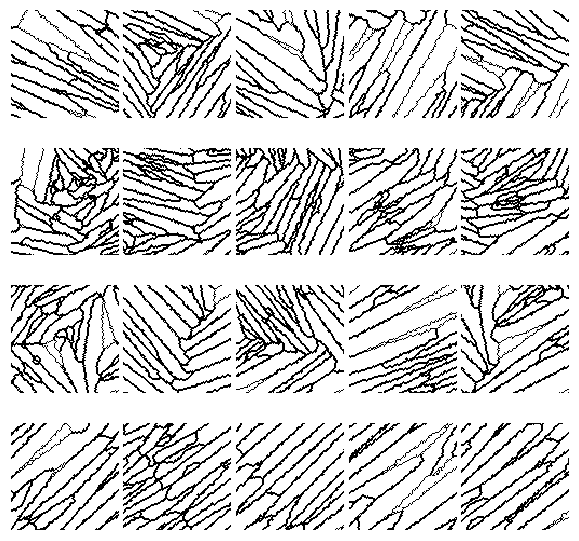

In [4]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(4, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(100, 100), cmap='Greys_r')
%matplotlib inline
A=images[0:mb_size]
plot(A)

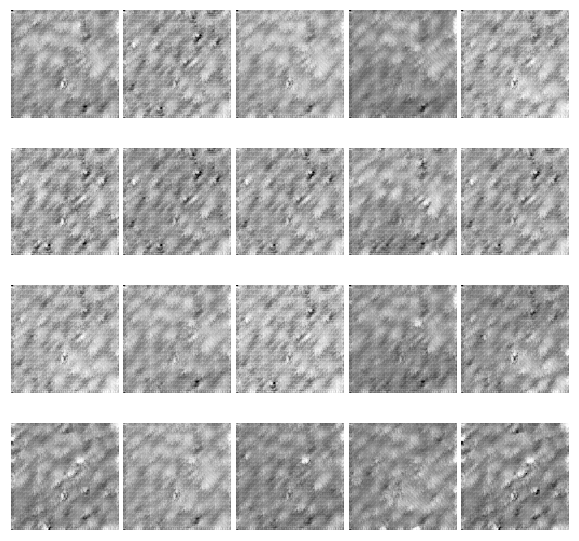

In [12]:
X_mb=images[0:mb_size]
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(sample_temp)

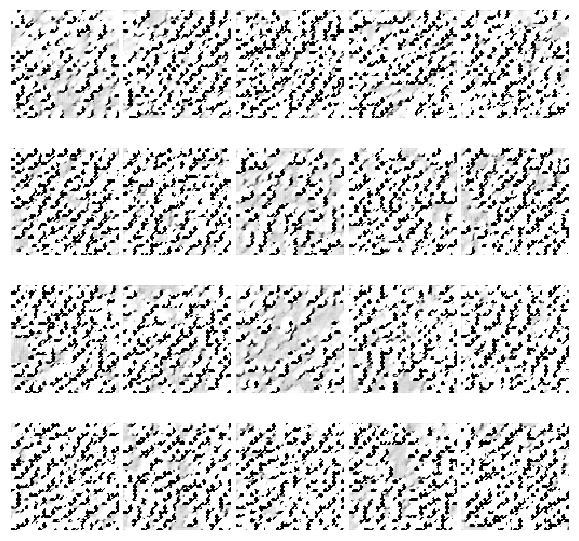

In [11]:
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
# sio.savemat('content_test.mat',mdict={'samples':samples})
plot(samples)

In [17]:
images_style.shape

(10000,)

In [10]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(600000):
#     X_mb = images[(it*10)%100:(it*10)%100+mb_size]
    X_mb = images[random.sample(range(len(images)),  mb_size)]
    images_style = images[random.sample(range(len(images)),  mb_size)]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     _, loss, recon_E, kl_E = sess.run([solver_VAE0, vae_loss, recon_loss, kl_loss], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim)})
    
#    
    _, loss_tot, recon_E, kl_E, style_E1, style_E2= sess.run([solver_ST0, tot_loss, recon_loss, kl_loss, sl1, sl2], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images_style.reshape(mb_size,100,100,1)})

    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E1:{}'.format(style_E1))
        print('style_E2:{}'.format(style_E2))
#         print('Var_E:{}'.format(Var_E))
        print()

#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 26650.1621094
recon_E:457.146728516
kl_E:36.0999450684
style_E1:202.278182983
style_E2:25954.6367188
()
Iter: 1000
Loss: 621.409851074
recon_E:412.93536377
kl_E:31.7562046051
style_E1:108.246658325
style_E2:68.4716339111
()
Iter: 2000
Loss: 1081.98144531
recon_E:425.918457031
kl_E:29.537071228
style_E1:110.537643433
style_E2:515.98828125
()
Iter: 3000
Loss: 970.653564453
recon_E:433.240997314
kl_E:33.5283050537
style_E1:176.745986938
style_E2:327.138275146
()
Iter: 4000
Loss: 593.680297852
recon_E:419.710876465
kl_E:31.1902427673
style_E1:58.6472167969
style_E2:84.1319656372
()
Iter: 5000
Loss: 1248.27514648
recon_E:425.602539062
kl_E:34.3408508301
style_E1:318.604400635
style_E2:469.727294922
()
Iter: 6000
Loss: 45421.5859375
recon_E:433.833374023
kl_E:33.0015144348
style_E1:355.673980713
style_E2:44599.078125
()
Iter: 7000
Loss: 814.9609375
recon_E:442.847991943
kl_E:31.6084632874
style_E1:72.054725647
style_E2:268.449768066
()
Iter: 8000
Loss: 836.27911377
recon_E:444.

KeyboardInterrupt: 

In [11]:
# conv_out1
conv_out1_test = sess.run(conv_out1,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images[25].reshape(1,100,100,1)})
# conv_out1_S_test = sess.run(conv_out1_S,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim),
#                                                               style_image: images[0].reshape(1,32,32,1)})

In [13]:
conv_out1_S_test = sess.run(conv_out1_S,feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images[25].reshape(1,100,100,1)})


(array([  4.90800000e+03,   7.00000000e+00,   4.00000000e+00,
          6.00000000e+00,   8.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   7.00000000e+00,   3.00000000e+00,
          5.30000000e+01]),
 array([ 0.        ,  0.09999897,  0.19999795,  0.29999692,  0.3999959 ,
         0.49999487,  0.59999385,  0.69999282,  0.7999918 ,  0.89999077,
         0.99998975]),
 <a list of 10 Patch objects>)

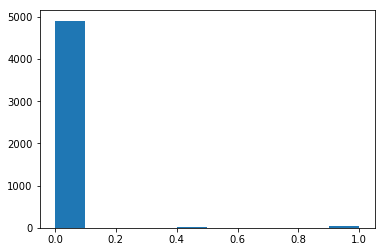

In [14]:
plt.hist(conv_out1_S_test.reshape(-1))

(array([  4.91200000e+03,   1.40000000e+01,   8.00000000e+00,
          8.00000000e+00,   4.00000000e+00,   8.00000000e+00,
          1.30000000e+01,   9.00000000e+00,   8.00000000e+00,
          1.60000000e+01]),
 array([ 0.        ,  0.09903744,  0.19807489,  0.29711233,  0.39614978,
         0.49518722,  0.59422467,  0.69326211,  0.79229956,  0.891337  ,
         0.99037445]),
 <a list of 10 Patch objects>)

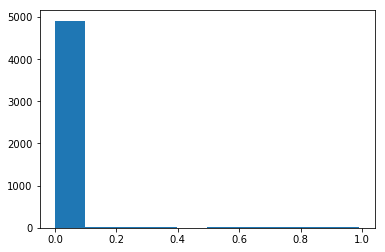

In [15]:
plt.hist(conv_out1_test.reshape(-1))

In [16]:
def get_shape(inp):
    # returns the shape of a tensor or an array
    if type(inp) == type(np.array([])):
        return inp.shape
    else:
        return [i.value for i in inp.get_shape()]

(array([ 3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

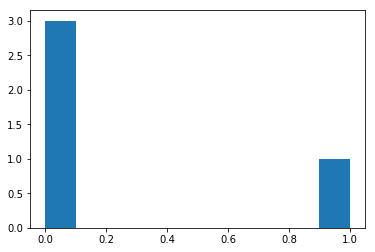

In [17]:
temp=conv_out1_test.reshape(-1, get_shape(conv_out1_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
# temp_tot=(temp_tot-np.mean(temp_tot))/np.std(temp_tot)
temp_tot=(temp_tot-np.min(temp_tot.reshape(-1)))/(np.max(temp_tot.reshape(-1))-np.min(temp_tot.reshape(-1)))

plt.hist(temp_tot.reshape(-1))

(array([ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

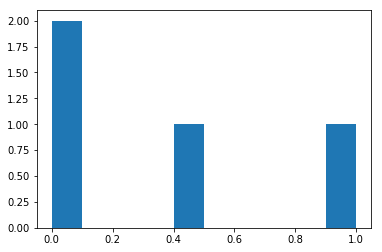

In [18]:
conv_out1_S_test = sess.run(conv_out1_S,feed_dict={style_image: images_style.reshape(1,100,100,1)})
temp=conv_out1_S_test.reshape(-1, get_shape(conv_out1_S_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot_S=np.dot(temp.T,temp)
# temp_tot=(temp_tot-np.mean(temp_tot))/np.std(temp_tot)
temp_tot_S=(temp_tot_S-np.min(temp_tot_S.reshape(-1)))/(np.max(temp_tot_S.reshape(-1))-np.min(temp_tot_S.reshape(-1)))

plt.hist(temp_tot_S.reshape(-1))

(array([  90.,  145.,  149.,  123.,   41.,   22.,    2.,    3.,    0.,    1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

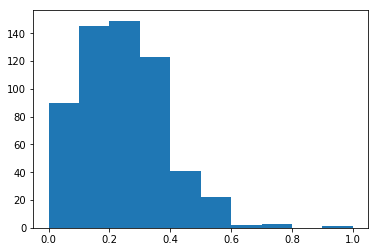

In [25]:
# conv_out1
conv_out1_test = sess.run(conv_out1,feed_dict={combination_image: samples[0].reshape(1,32,32,1)})
temp=conv_out1_test.reshape(-1, get_shape(conv_out1_test)[3])
# temp=(temp-np.mean(temp))/np.std(temp)
temp_tot=np.dot(temp.T,temp)
temp_tot=(temp_tot-np.min(temp_tot.reshape(-1)))/(np.max(temp_tot.reshape(-1))-np.min(temp_tot.reshape(-1)))

plt.hist(temp_tot.reshape(-1))

In [31]:
A=np.array([[1,2,3],[4,5,6]])


array([[14, 32],
       [32, 77]])

In [37]:
np.mean(np.square(temp_tot-temp_tot_S))

0.00043939624

In [151]:
save_path = saver.save(sess, "/tmp/model.ckpt")
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")

for it in range(400000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     _, loss, recon_E, kl_E = sess.run([solver, vae_loss, recon_loss, kl_loss], 
#                                                     feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
#                                                               z: np.random.randn(mb_size, z_dim)})
    _, loss_tot, recon_E, kl_E, style_E= sess.run([solver2, tot_loss, recon_loss, kl_loss, sl1], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z: np.random.randn(mb_size, z_dim),
                                                              style_image: images_style.reshape(1,100,100,1)})

    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss_tot))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
        print('style_E:{}'.format(style_E))
#         print('Var_E:{}'.format(Var_E))
        print()

#         samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})

#         fig = plot(samples)
#         plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
#         i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 0
Loss: 109.218139648
recon_E:60.6504898071
kl_E:33.6590118408
style_E:5.08268547058
()
Iter: 1000
Loss: 81.1686019897
recon_E:39.0911941528
kl_E:33.5824127197
style_E:1.45243608952
()
Iter: 2000
Loss: 87.9397506714
recon_E:42.7844619751
kl_E:33.3720550537
style_E:2.51881146431
()
Iter: 3000
Loss: 88.1022109985
recon_E:43.8763465881
kl_E:33.7444267273
style_E:2.39647912979
()
Iter: 4000
Loss: 82.0798797607
recon_E:38.22996521
kl_E:33.5617446899
style_E:2.13005638123
()
Iter: 5000
Loss: 88.5453338623
recon_E:42.7216567993
kl_E:33.8388137817
style_E:2.5379087925
()
Iter: 6000
Loss: 89.8638153076
recon_E:47.3154144287
kl_E:33.1777229309
style_E:1.64709532261
()
Iter: 7000
Loss: 91.6103973389
recon_E:46.5632400513
kl_E:33.4258956909
style_E:2.72247695923
()
Iter: 8000
Loss: 96.4542922974
recon_E:53.8019790649
kl_E:33.20728302
style_E:3.04542660713
()
Iter: 9000
Loss: 90.2174987793
recon_E:45.7562294006
kl_E:33.1273765564
style_E:2.58134150505
()
Iter: 10000
Loss: 108.29384613
recon_E

KeyboardInterrupt: 

In [19]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(100, 100), cmap='Greys_r')

X_mb=images[30:35]
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})
# plot_new(sample_temp)
plot(sample_temp)

ValueError: total size of new array must be unchanged

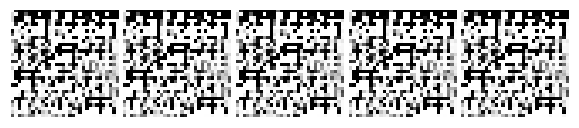

In [10]:
def plot(samples):
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(1, 5)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

#     return fig
samples = sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
sample_sort=samples.reshape(-1)
# sample_sort.sort()
# samples[samples>=(np.sort(sample_sort))[300]]=1
# samples[samples<(np.sort(sample_sort))[300]]=-1
plot(samples)

In [75]:
def correlation_fun_test(xx,input_dim,Rad):
    sum_store=[]
    for ii in range(len(xx)):
        x = xx[ii]
        point_corr=0
#     if Rad <=50:
        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp1=(x[i,j]*x[i,np.mod(j+Rad,input_dim)])
                point_corr=point_corr_temp1+point_corr

        for i in range(input_dim):
            for j in range(input_dim):
                point_corr_temp2=x[i,j]*x[np.mod(i+Rad,input_dim),j]
                point_corr=(point_corr_temp2+point_corr)
        sum_store.append((point_corr+2*input_dim**2)/4.)
#     print(point_corr)
    return sum_store

In [76]:
S2 = np.zeros([2*mb_size,17])
for i in range(2):
    samples=sess.run(X_samples, feed_dict={z: np.random.randn(mb_size, z_dim)})
    for j in range(17):
        S2[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=samples,input_dim=32,Rad=j)
#     plt.hist(samples.reshape(-1))

S2_ori = np.zeros([2*mb_size,17])
for i in range(2):
    for j in range(17):
        sample_ori=images[i*mb_size:(i+1)*mb_size].reshape(mb_size,32,32,1)
        S2_ori[i*mb_size:(i+1)*mb_size,j] = correlation_fun_test(xx=sample_ori,input_dim=32,Rad=j)

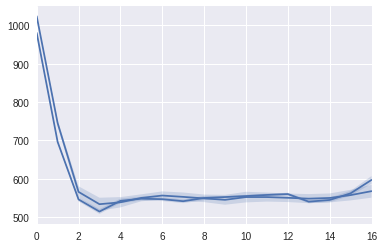

In [77]:
import seaborn as sns
%matplotlib inline
x = np.linspace(0, 16, 17)
sns.tsplot(data=S2)
sns.tsplot(data=S2_ori)

In [138]:
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
print z_temp.shape
test1=z_temp[1,:]
sample_temp=sess.run(X_samples, feed_dict={z: z_temp[0:mb_size]})

(5, 8)


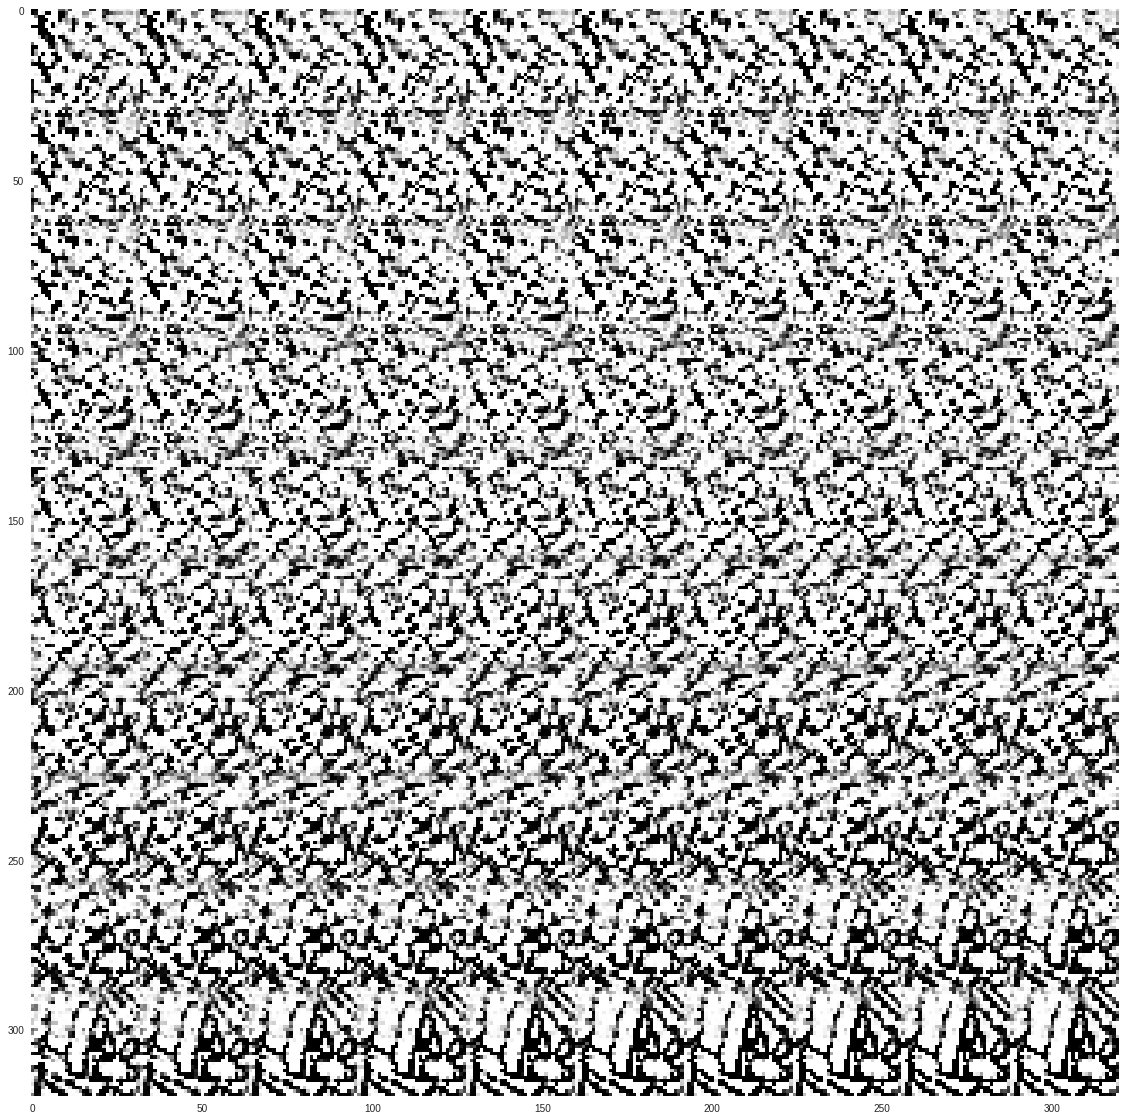

In [139]:
import matplotlib.pyplot as plt
n = 10  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)
k=0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        xi=np.linspace(-2, 2, 100)[k];k=k+1
        z_sample = np.array([[xi,test1[1],test1[2],test1[3],test1[4],test1[5],test1[6],test1[7]]]) 
#         z_sample = z_temp[3]
        z_temp[0] = z_sample
        x_decoded = (sess.run(X_samples, feed_dict={z: z_temp}))
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.grid(False)
plt.imshow(figure,'gray')
plt.show()

ValueError: total size of new array must be unchanged

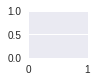

In [140]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 32  # how many digits we will display
plt.figure(figsize=(10, 4))
for i in range(n):
    # display original
    ax = plt.subplot(4, n/4, i + 1)
    plt.imshow(W3[:,:,:,i].reshape(4, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Using TensorFlow backend.


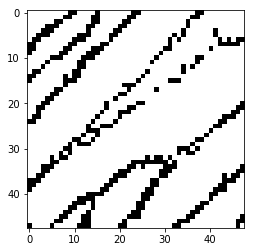

In [1]:
import scipy.io as sio
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import tensorflow as tf
height=48
width =48
W1 = np.array(sio.loadmat('W1_Ti.mat')['W1'],dtype='float32')
W2 = np.array(sio.loadmat('W2_Ti.mat')['W2'],dtype='float32')
W3 = np.array(sio.loadmat('W3_Ti.mat')['W3'],dtype='float32')
images = np.array(sio.loadmat('WB_test64_GAN_sm.mat')['WB_sm'],dtype='float32')
style_img=images[3].reshape(1,height,width,1)
plt.imshow(style_img.reshape(height,width),'gray')

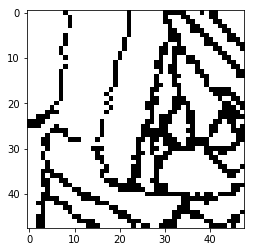

In [2]:
content_img=images[1].reshape(1,height,width,1)
plt.imshow(content_img.reshape(height,width),'gray')

In [3]:
style_image = backend.variable(style_img)
content_image = backend.variable(content_img)
combination_image = backend.placeholder((1, height, width, 1))

In [4]:
def conv2d(x, W, stride, padding="SAME"):
        return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    
def max_pool(x, k_size, stride, padding="VALID"):
    # use avg pooling instead, as described in the paper
    return tf.nn.avg_pool(x, ksize=[1, k_size, k_size, 1], 
            strides=[1, stride, stride, 1], padding=padding)    

def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 1
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))*10000

In [5]:
import tensorflow as tf
W_conv1 = tf.reshape(tf.constant(W1),[6,6,1,24])
W_conv2 = tf.reshape(tf.constant(W2),[9,9,24,40])
W_conv3 = tf.reshape(tf.constant(W3),[9,9,40,288])

############# white noise ############
conv_out1 = conv2d(combination_image, W_conv1, stride=1, padding='SAME')
conv_out1 = tf.nn.sigmoid(conv_out1)
conv_out1 = max_pool(conv_out1, k_size=2, stride=2, padding="SAME")

# conv_out2 = conv2d(conv_out1, W_conv2, stride=1, padding='SAME')
# conv_out2 = tf.nn.sigmoid(conv_out2)
# conv_out2 = max_pool(conv_out2, k_size=2, stride=2, padding="SAME")

# conv_out3 = conv2d(conv_out2, W_conv3, stride=1, padding='SAME')
# conv_out3 = tf.nn.sigmoid(conv_out3)

############# style image ############
conv_out1_S = conv2d(style_image, W_conv1, stride=1, padding='SAME')
conv_out1_S = tf.nn.sigmoid(conv_out1_S)
conv_out1_S = max_pool(conv_out1_S, k_size=2, stride=2, padding="SAME")

# conv_out2_S = conv2d(conv_out1_S, W_conv2, stride=1, padding='SAME')
# conv_out2_S = tf.nn.sigmoid(conv_out2_S)
# conv_out2_S = max_pool(conv_out2_S, k_size=2, stride=2, padding="SAME")

# conv_out3_S = conv2d(conv_out2_S, W_conv3, stride=1, padding='SAME')
# conv_out3_S = tf.nn.sigmoid(conv_out3_S)

############# content image ############
conv_out1_C = conv2d(content_image, W_conv1, stride=1, padding='SAME')
conv_out1_C = tf.nn.sigmoid(conv_out1_C)
conv_out1_C = max_pool(conv_out1_C, k_size=2, stride=2, padding="SAME")

In [6]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

content_image_features = conv_out1_C
combination_features = conv_out1

cl = content_loss(content_image_features,combination_features)*10000

In [7]:
loss = backend.variable(0.)

sl1 = style_loss(conv_out1[0,:,:,:], conv_out1_S[0,:,:,:])
# sl2 = style_loss(conv_out2[0,:,:,:], conv_out2_S[0,:,:,:])
# sl3 = style_loss(conv_out3[0,:,:,:], conv_out3_S[0,:,:,:])

loss = sl1 + cl

grads = backend.gradients(loss, combination_image)

In [8]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 1))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [15]:
x = np.random.uniform(-1, 1, (1, height, width, 1))

iterations = 4000

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=40)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', 9903663.0)
Iteration 0 completed in 0s
('Start of iteration', 1)
('Current loss value:', 5087829.5)
Iteration 1 completed in 0s
('Start of iteration', 2)
('Current loss value:', 4426694.5)
Iteration 2 completed in 0s
('Start of iteration', 3)
('Current loss value:', 3854667.2)
Iteration 3 completed in 0s
('Start of iteration', 4)
('Current loss value:', 3366360.0)
Iteration 4 completed in 0s
('Start of iteration', 5)
('Current loss value:', 2951377.8)
Iteration 5 completed in 0s
('Start of iteration', 6)
('Current loss value:', 2598152.2)
Iteration 6 completed in 0s
('Start of iteration', 7)
('Current loss value:', 2296351.5)
Iteration 7 completed in 0s
('Start of iteration', 8)
('Current loss value:', 2037489.5)
Iteration 8 completed in 0s
('Start of iteration', 9)
('Current loss value:', 1814755.9)
Iteration 9 completed in 0s
('Start of iteration', 10)
('Current loss value:', 1622582.9)
Iteration 10 completed in 0s
('Start of iteratio

KeyboardInterrupt: 

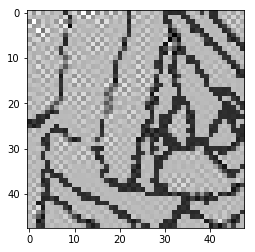

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
x = x.reshape((height, width, 1))
plt.imshow(x.reshape(48,48),'gray')